In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Feb 10 17:23:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 32%   54C    P2             173W / 450W |  23299MiB / 24564MiB |     47%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.dropout_wise_min_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 1024
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 13.992919921875
encoder.convs 5.989013671875
encoder.linear 8.00390625
prior 0.0
latent 0.0
decoder 14.028697967529297
decoder.linear 8.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.10-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 50532
-rw-rw-r-- 1 scpark scpark  1281034  2월 10 17:23 events.out.tfevents.1707552872.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 50462060  2월 10 17:14 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


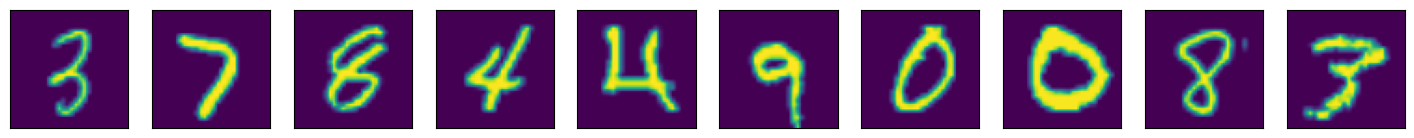

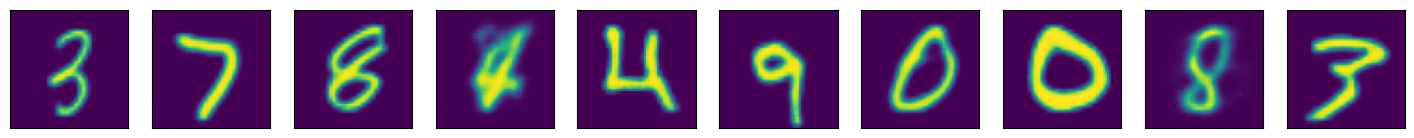

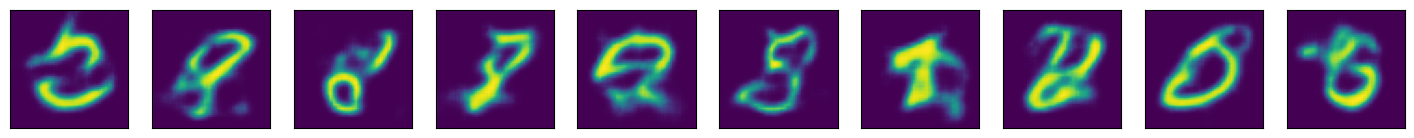

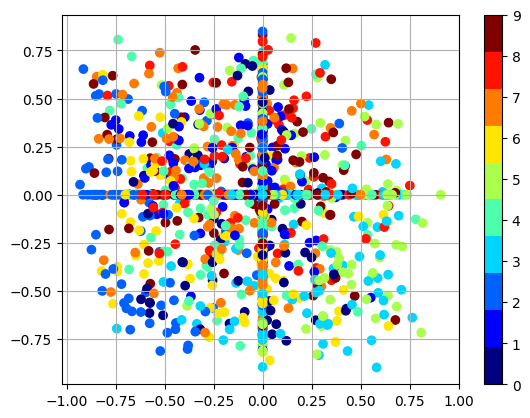

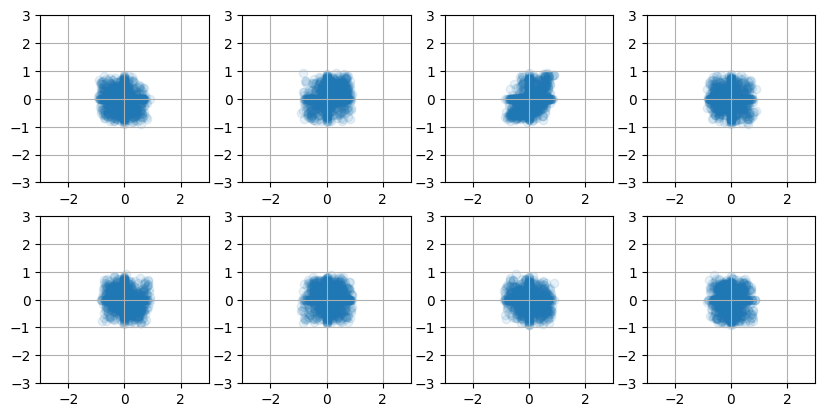

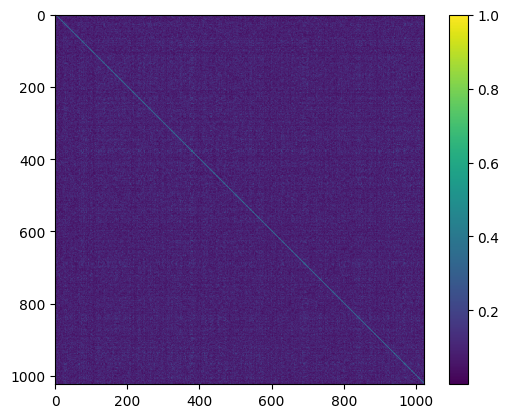

9001
min_loss 431.95965576171875
wise_min_loss 0.0018421810818836093
recon_loss 0.019200941547751427
9002
min_loss 432.9187316894531
wise_min_loss 0.0016526191029697657
recon_loss 0.017789382487535477
9003
min_loss 428.35296630859375
wise_min_loss 0.0017549156909808517
recon_loss 0.019832434132695198
9004
min_loss 424.5045166015625
wise_min_loss 0.0018685187678784132
recon_loss 0.019490700215101242
9005
min_loss 431.3116455078125
wise_min_loss 0.0018365586875006557
recon_loss 0.018299981951713562
9006
min_loss 432.55780029296875
wise_min_loss 0.0018814443610608578
recon_loss 0.02207466959953308
9007
min_loss 423.1283264160156
wise_min_loss 0.0018693733727559447
recon_loss 0.01865331083536148
9008
min_loss 429.04876708984375
wise_min_loss 0.001764326123520732
recon_loss 0.01710079237818718
9009
min_loss 424.65435791015625
wise_min_loss 0.0018446630565449595
recon_loss 0.021985724568367004
9010
min_loss 423.0389404296875
wise_min_loss 0.001990425866097212
recon_loss 0.01982104405760765
9

9084
min_loss 429.01226806640625
wise_min_loss 0.0018815789371728897
recon_loss 0.01862446591258049
9085
min_loss 419.9322509765625
wise_min_loss 0.0021462514996528625
recon_loss 0.02107011340558529
9086
min_loss 433.74713134765625
wise_min_loss 0.0015935789560899138
recon_loss 0.02012529969215393
9087
min_loss 427.3766784667969
wise_min_loss 0.0019074489828199148
recon_loss 0.017850032076239586
9088
min_loss 427.177001953125
wise_min_loss 0.0018177719321101904
recon_loss 0.018284432590007782
9089
min_loss 423.93450927734375
wise_min_loss 0.0019195484928786755
recon_loss 0.020079243928194046
9090
min_loss 419.3251953125
wise_min_loss 0.0019221927504986525
recon_loss 0.019506126642227173
9091
min_loss 429.66461181640625
wise_min_loss 0.0017122463323175907
recon_loss 0.020861122757196426
9092
min_loss 418.74468994140625
wise_min_loss 0.002015279605984688
recon_loss 0.01886795461177826
9093
min_loss 419.8254089355469
wise_min_loss 0.001776843098923564
recon_loss 0.018308188766241074
9094


9167
min_loss 428.77435302734375
wise_min_loss 0.0019367850618436933
recon_loss 0.018723566085100174
9168
min_loss 423.5174560546875
wise_min_loss 0.002313824836164713
recon_loss 0.017008686438202858
9169
min_loss 428.8880920410156
wise_min_loss 0.0020326043013483286
recon_loss 0.01954914629459381
9170
min_loss 428.19757080078125
wise_min_loss 0.0019540847279131413
recon_loss 0.01624034158885479
9171
min_loss 429.30340576171875
wise_min_loss 0.0019180327653884888
recon_loss 0.020137816667556763
9172
min_loss 427.7240295410156
wise_min_loss 0.0019077204633504152
recon_loss 0.01866934821009636
9173
min_loss 425.35882568359375
wise_min_loss 0.001967795193195343
recon_loss 0.017733965069055557
9174
min_loss 433.1291809082031
wise_min_loss 0.0018690626602619886
recon_loss 0.020016010850667953
9175
min_loss 422.57318115234375
wise_min_loss 0.0021551591344177723
recon_loss 0.020373128354549408
9176
min_loss 427.7599182128906
wise_min_loss 0.0020529169123619795
recon_loss 0.02179088443517685
9

9250
min_loss 422.6046142578125
wise_min_loss 0.001889120088890195
recon_loss 0.01670798659324646
9251
min_loss 430.0646057128906
wise_min_loss 0.001858381787315011
recon_loss 0.017332671210169792
9252
min_loss 419.25341796875
wise_min_loss 0.0021204210352152586
recon_loss 0.021273255348205566
9253
min_loss 425.17669677734375
wise_min_loss 0.0020496309734880924
recon_loss 0.020651990547776222
9254
min_loss 435.646484375
wise_min_loss 0.0016640727408230305
recon_loss 0.022754153236746788
9255
min_loss 430.583984375
wise_min_loss 0.0017307919915765524
recon_loss 0.02031591720879078
9256
min_loss 428.54107666015625
wise_min_loss 0.001964628230780363
recon_loss 0.01759045198559761
9257
min_loss 421.3772277832031
wise_min_loss 0.0017905703280121088
recon_loss 0.01650156080722809
9258
min_loss 412.73870849609375
wise_min_loss 0.0023667537607252598
recon_loss 0.019403155893087387
9259
min_loss 422.2967834472656
wise_min_loss 0.0017293124692514539
recon_loss 0.01891394704580307
9260
min_loss 4

min_loss 433.48126220703125
wise_min_loss 0.0017339761834591627
recon_loss 0.02348215878009796
9335
min_loss 430.0380859375
wise_min_loss 0.0016773329116404057
recon_loss 0.01682666689157486
9336
min_loss 426.331298828125
wise_min_loss 0.002095506526529789
recon_loss 0.0205979123711586
9337
min_loss 423.4835205078125
wise_min_loss 0.0021110496018081903
recon_loss 0.01976829394698143
9338
min_loss 419.12066650390625
wise_min_loss 0.0020620678551495075
recon_loss 0.017017334699630737
9339
min_loss 432.9913330078125
wise_min_loss 0.0018392432248219848
recon_loss 0.02017495408654213
9340
min_loss 417.8932189941406
wise_min_loss 0.0025269626639783382
recon_loss 0.018913324922323227
9341
min_loss 428.1658935546875
wise_min_loss 0.0019180241506546736
recon_loss 0.020270081236958504
9342
min_loss 422.326171875
wise_min_loss 0.0018928037025034428
recon_loss 0.01987033151090145
9343
min_loss 428.43695068359375
wise_min_loss 0.00195584399625659
recon_loss 0.0190244372934103
9344
min_loss 432.8781

9418
min_loss 426.64312744140625
wise_min_loss 0.0018090419471263885
recon_loss 0.01720166578888893
9419
min_loss 433.2015075683594
wise_min_loss 0.001838482916355133
recon_loss 0.020549941807985306
9420
min_loss 428.7622375488281
wise_min_loss 0.001987815834581852
recon_loss 0.019127914682030678
9421
min_loss 426.3417053222656
wise_min_loss 0.0019537496846169233
recon_loss 0.014309550635516644
9422
min_loss 432.20965576171875
wise_min_loss 0.0018113539554178715
recon_loss 0.01790015399456024
9423
min_loss 421.26019287109375
wise_min_loss 0.0022192569449543953
recon_loss 0.02079666219651699
9424
min_loss 419.67047119140625
wise_min_loss 0.0018265838734805584
recon_loss 0.01495288871228695
9425
min_loss 424.75787353515625
wise_min_loss 0.0019569762516766787
recon_loss 0.021547844633460045
9426
min_loss 428.15289306640625
wise_min_loss 0.0016558505594730377
recon_loss 0.01871054619550705
9427
min_loss 427.0860595703125
wise_min_loss 0.0018173824064433575
recon_loss 0.01775151863694191
94

min_loss 424.09429931640625
wise_min_loss 0.0019052366260439157
recon_loss 0.017390858381986618
9503
min_loss 435.84912109375
wise_min_loss 0.0018183462088927627
recon_loss 0.016104787588119507
9504
min_loss 440.7253723144531
wise_min_loss 0.0016337428241968155
recon_loss 0.01931992918252945
9505
min_loss 432.7543029785156
wise_min_loss 0.0019521026406437159
recon_loss 0.020071154460310936
9506
min_loss 434.36322021484375
wise_min_loss 0.0017919903621077538
recon_loss 0.01948959194123745
9507
min_loss 429.297119140625
wise_min_loss 0.0020323172211647034
recon_loss 0.020757019519805908
9508
min_loss 435.4842834472656
wise_min_loss 0.0017846741247922182
recon_loss 0.01940564624965191
9509
min_loss 430.1619567871094
wise_min_loss 0.001979466527700424
recon_loss 0.024951990693807602
9510
min_loss 432.66546630859375
wise_min_loss 0.0018365565920248628
recon_loss 0.017867160961031914
9511
min_loss 427.580810546875
wise_min_loss 0.0018122524488717318
recon_loss 0.02078239992260933
9512
min_lo

9585
min_loss 427.42669677734375
wise_min_loss 0.0019044838845729828
recon_loss 0.021403400227427483
9586
min_loss 426.13525390625
wise_min_loss 0.0022697770036756992
recon_loss 0.01630920171737671
9587
min_loss 427.3375244140625
wise_min_loss 0.0020262475591152906
recon_loss 0.02065970003604889
9588
min_loss 423.431396484375
wise_min_loss 0.0023460639640688896
recon_loss 0.017851417884230614
9589
min_loss 436.031982421875
wise_min_loss 0.0015717020723968744
recon_loss 0.023858796805143356
9590
min_loss 429.728271484375
wise_min_loss 0.0018237753538414836
recon_loss 0.02016511932015419
9591
min_loss 432.3797607421875
wise_min_loss 0.0018400687258690596
recon_loss 0.019185058772563934
9592
min_loss 425.7130126953125
wise_min_loss 0.0020004017278552055
recon_loss 0.019910460337996483
9593
min_loss 428.091796875
wise_min_loss 0.0017744554206728935
recon_loss 0.020411944016814232
9594
min_loss 418.033203125
wise_min_loss 0.0018055333057418466
recon_loss 0.020620916038751602
9595
min_loss 4

min_loss 417.76654052734375
wise_min_loss 0.002033025026321411
recon_loss 0.0186195969581604
9670
min_loss 431.8447265625
wise_min_loss 0.0017652439419180155
recon_loss 0.018820060417056084
9671
min_loss 420.1585693359375
wise_min_loss 0.00212370278313756
recon_loss 0.015831321477890015
9672
min_loss 424.53143310546875
wise_min_loss 0.002051562536507845
recon_loss 0.01697566732764244
9673
min_loss 417.5755310058594
wise_min_loss 0.00201113591901958
recon_loss 0.017395656555891037
9674
min_loss 422.2524108886719
wise_min_loss 0.0020950487814843655
recon_loss 0.02109457179903984
9675
min_loss 422.7103271484375
wise_min_loss 0.0022523347288370132
recon_loss 0.019263260066509247
9676
min_loss 440.337158203125
wise_min_loss 0.001680571585893631
recon_loss 0.019333310425281525
9677
min_loss 427.7175598144531
wise_min_loss 0.0018094780389219522
recon_loss 0.0236732866615057
9678
min_loss 411.85498046875
wise_min_loss 0.002471884246915579
recon_loss 0.016443705186247826
9679
min_loss 421.43350

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f45fe72a270>>
Traceback (most recent call last):
  File "/home/scpark/anaconda3/envs/ste/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'min_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                #z = torch.randn(10, hp.z_dim).to(device)
                z = z * data['z'].std(dim=0)[None, :]
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-3, 3])
                plt.ylim([-3, 3])

            plt.show()
            
            coef = torch.corrcoef(data['z'].T).abs().data.cpu().numpy()
            plt.imshow(coef)
            plt.colorbar()
            plt.show()

            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    z = z * 0.5
    y = model.sample(z)
    plot(y)